# Fraudulent User Detection Using Amazon Dataset
### Penghao Xu, Yuan Chen, Jiawei Wu, Haojing Lu

## Part 3. Proposed New Methods

This script is used to apply our proposed new model to fraudulent user detection on Amazon review dataset.


In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

torch.manual_seed(3407)

In [4]:
# inputs
files = {}
files['train'] = f'dataset/toy_embedded_review.csv'
files['val'] = f'dataset/toy_embedded_review.csv'
files['test'] = f'dataset/toy_embedded_review.csv'
files['all'] = f'dataset/toy_embedded_review.csv'

# labels
label_files = {}
label_files['train'] = f'dataset/toy_user_label.csv'
label_files['val'] = f'dataset/toy_user_label.csv'
label_files['test'] = f'dataset/toy_user_label.csv'
label_files['all'] = f'dataset/toy_user_label.csv'

In [5]:
# check cuda availablity
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

### Load data
Here, we load all scores and embeddings and group them in each user

In [12]:
# load data and group by products
def load_data(datafile):
    with open(datafile, 'r') as fr:
        data = {}
        for l in fr:
            ws = l.rstrip('\n').split(',')
            emb_dim = len(ws) - 2
            if ws[1] not in data:
                data[ws[1]] = []
            data[ws[1]].append([ws[0], ws[1], torch.tensor([float(x) for x in ws[2:]])])
    return data, emb_dim

# load labels and sort in users order
def load_labels(labelfile, device):
    with open(labelfile, 'r') as fr:
        fr.readline()
        user_labels = []
        for l in fr:
            ws = l.rstrip('\n').split(',')
            user_labels.append((ws[0], float(ws[1])))
        user_labels.sort()
        user_labels = torch.tensor([x[1] for x in user_labels]).to(device)
    return user_labels

In [13]:
# load all, train, val, and test files
data = {}
labels = {}
for t in ['train', 'val', 'test', 'all']:
    if t in files and t in label_files:
        data[t], emb_dim = load_data(files[t])
        labels[t] = load_labels(label_files[t], device)
        print(f'Statistics for {t} dataset:')
        print(f'Total users: {len(labels[t])}')
        print(f'Total products: {len(data[t])}')

Statistics for train dataset:
Total users: 12734
Total products: 18525
Statistics for val dataset:
Total users: 12734
Total products: 18525
Statistics for test dataset:
Total users: 12734
Total products: 18525
Statistics for all dataset:
Total users: 12734
Total products: 18525


### Build model
This model takes the text embeddings and scores to predict the user helpfulness and detect fraudulent users using the following formula:

$$
\overrightarrow{G(p)} = AGG(RNN(\overrightarrow{S(u, p)}, \forall u \in U),  \Pi_p)
$$
$$
\overrightarrow{R(u, p)} = NN(\overrightarrow{S(u, p)}, \overrightarrow{G(p)})
$$
$$
F(u) = AGG(\overrightarrow{R(u, p)}, \forall p \in P, \overrightarrow{\Pi_u}) 
$$

In this very first model, the product and user embeddings are removed. We used the following formula:
$$
\overrightarrow{G(p)} = GRU(\overrightarrow{S(u, p)}, \forall u \in U)
$$
$$
\overrightarrow{R(u, p)} = NN(\overrightarrow{S(u, p)}, \overrightarrow{G(p)})
$$
$$
F(u) = GRU(\overrightarrow{R(u, p)}, \forall p \in P) 
$$

In [15]:
# helper function to convert text embeddings of a product
def emb2tensor(data, dim):
    product = data[0][1]
    tensor = torch.zeros((len(data), 1, dim))
    for i, d in enumerate(data):
        tensor[i,:,:] = d[-1]
    return tensor, product
emb2tensor(data['train'][list(data['train'].keys())[0]], emb_dim)

(tensor([[[ 5.0000e-01,  2.7292e+00, -4.1624e-01, -8.0864e-01,  7.4878e-01,
            2.5790e-01, -2.0068e-01, -4.3292e-01, -7.7429e-01, -1.9938e-01,
            1.2567e-01,  3.7410e-01,  5.5511e-02, -2.5312e-01,  1.6074e-01,
            1.3909e-01,  1.3617e-02,  7.9579e-02, -6.6650e-02,  1.2255e-01,
            9.5400e-02]],
 
         [[ 1.0000e+00, -6.2331e+00,  1.2535e+00, -1.1915e-01,  8.1381e-02,
            4.7569e-02,  1.9290e-02,  3.6569e-02, -1.6166e-02, -4.6427e-03,
            7.9938e-02,  9.1746e-02,  3.5788e-02, -7.9514e-02,  7.6651e-02,
            9.8112e-02, -4.2680e-02, -7.7973e-02, -2.0858e-01,  4.2270e-03,
           -1.3355e-01]],
 
         [[ 5.0000e-01,  8.3766e+00,  1.1362e+00, -1.3885e+00,  3.1851e-01,
            7.3440e-01, -3.6046e-01,  7.5319e-01, -3.7999e-01,  5.0391e-01,
           -7.1455e-02, -3.5825e-01, -1.0929e+00,  4.1422e-01, -3.1756e-01,
            2.9747e-03, -2.8366e-01,  1.8401e-02, -3.3007e-02, -5.1558e-02,
            6.9910e-02]]]),
 '00

In [16]:
class FUD(nn.Module):
    def __init__(self, emb_dim, device):
        super().__init__()
        # get parameters
        self.dim = emb_dim
        # set layers
        self.GRU = nn.GRU(emb_dim, 32)
        self.fc1 = nn.Linear(emb_dim + 32, 16)
        self.fc2 = nn.Linear(16, 16)
        self.GRU2 = nn.GRU(16, 1)
        self.device = device
    
    def forward(self, x):
        # calculate gp
        gp = {}
        for su in x.values():
            tensor, p = emb2tensor(su, self.dim)
            gp[p] = self.GRU(tensor.to(self.device))[-1].view(-1)
        # calculate rup
        rup = {}
        for su in x.values():
            for r in su:
                u, p, s = r
                s = torch.cat((s.to(device), gp[p]))
                if u not in rup:
                    rup[u] = []
                rup[u].append(self.fc2(F.relu(self.fc1(s))))
        # fairness for users
        fu = []
        for u in sorted(rup.keys()):
            v = torch.stack(rup[u], dim=1).view(len(rup[u]), 1, 16)
            fu.append(self.GRU2(v)[-1])
        return torch.cat(fu)

### Train model

In [17]:
model = FUD(emb_dim, device).to(device)
model

FUD(
  (GRU): GRU(21, 32)
  (fc1): Linear(in_features=53, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (GRU2): GRU(16, 1)
)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-7)
criterion = nn.MSELoss()
epochs = 4
report_epoch = 2
train_losses = []
val_losses = []

for i in range(epochs):
    model.train()
    y_pred = model(data['train'])
    loss = criterion(y_pred.view(-1), labels['train'])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.view(-1).cpu().detach().numpy()[0])
    if not i % report_epoch:
        model.eval()
        pred = model(data['val'])
        val_loss = criterion(pred.view(-1), labels['val'])
        val_losses.append(val_loss.view(-1).cpu().detach().numpy()[0])
        print(f'Epoch {i}, Train Loss: {train_losses[-1]:.6f}, Val. Loss: {val_losses[-1]:.6f}')

Epoch 0, Train Loss: 0.841652, Val. Loss: 0.536394
Epoch 2, Train Loss: 0.301343, Val. Loss: 0.148347


Save model weights if needed

In [9]:
torch.save(model.state_dict(), 'Model_weights.tar')

Visualize training process

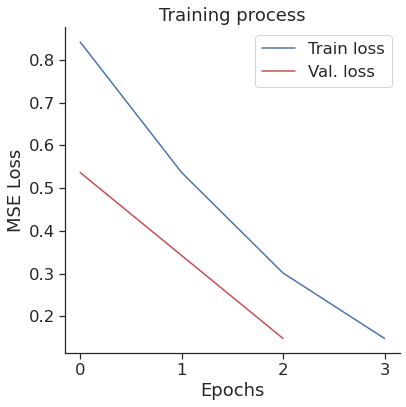

In [24]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(style='ticks', font_scale=1.5)
plt.plot(list(range(epochs)), train_losses, color='b', label='Train loss')
plt.plot(list(range(0, epochs, report_epoch)), val_losses, color='r', label='Val. loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.title('Training process')
plt.legend()
sns.despine()

Evaluate model on train, val, test, and all dataset

In [25]:
# generate labels
y_true = {}
for k, v in labels.items():
    y_true[k] = v.cpu().detach().numpy()
    y_true[k][y_true[k]>0.5] = 1
    y_true[k][y_true[k]<0.5] = 0

In [27]:
threshold = 0.5
model.eval()
preds = {}
for k, v in y_true.items():
    preds[k] = model(data[k]).view(-1).cpu().detach().numpy()
    preds[k][preds[k] > threshold] = 1
    preds[k][preds[k] < threshold] = 0
    acc = np.sum(preds[k] == v)/len(preds[k])
    print(f'Accuracy for {k} dataset: {acc:.4f}')

Accuracy for train dataset: 0.8682
Accuracy for val dataset: 0.8682
Accuracy for test dataset: 0.8682
Accuracy for all dataset: 0.8682


ROC curve and AUC

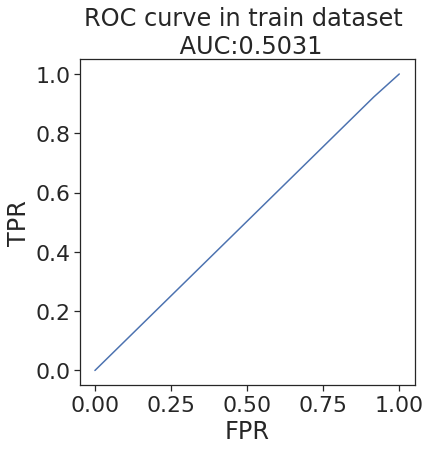

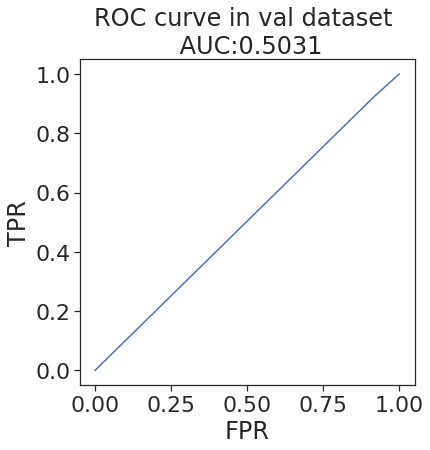

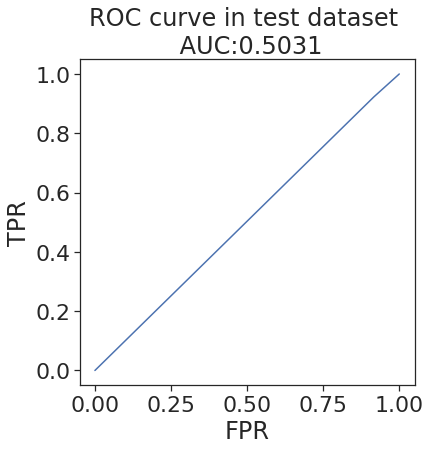

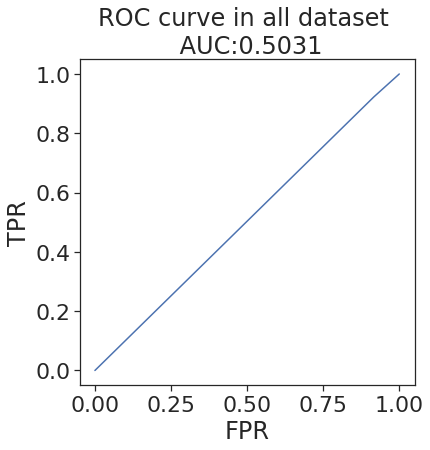

In [29]:
for k, v in y_true.items():
    fpr, tpr, _ = roc_curve(v, preds[k])
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(6,6))
    plt.plot(fpr, tpr)
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.title(f'ROC curve in {k} dataset \n AUC:{roc_auc:.4f}')